# Data Exploration Exercises


## 1. Spam Data

### a. Load the spam data set.

In [27]:
import pandas as pd
from prepare import basic_clean, lemmatize, remove_stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

# acquire data from spam_db
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")

In [2]:
df.shape

(5572, 2)

In [4]:
df.head

<bound method NDFrame.head of      label                                               text
id                                                           
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [3]:
# initial value counts
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
# combine cleaning function
def clean(text):
    return remove_stopwords(lemmatize(basic_clean(text)))

In [6]:
# clean text in spam data
df.text = df.text.apply(clean)

In [7]:
# check cleaned text
df.text.head()

id
0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: text, dtype: object

In [8]:
# categorize text
all_text = ' '.join(df.text)
spam_text = ' '.join(df[df.label == 'spam'].text)
ham_text = ' '.join(df[df.label == 'ham'].text)
all_text = clean(all_text)
spam_text = clean(spam_text)
ham_text = clean(ham_text)

In [9]:
# aggregate on word, check frequency for each word
pd.Series(all_text.split()).value_counts()

u           1183
call         600
2            478
im           462
get          397
            ... 
basket         1
dane           1
corrct         1
santha         1
bitching       1
Length: 8886, dtype: int64

In [10]:
# store value count into variable
ham_freq = pd.Series(ham_text.split()).value_counts()
spam_freq = pd.Series(spam_text.split()).value_counts()
all_freq = pd.Series(all_text.split()).value_counts()

In [11]:
# store word's frequency into dataframe
word_counts = pd.concat([all_freq, spam_freq, ham_freq], sort=True, axis=1)
word_counts.columns = ['all', 'spam', 'ham']
word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))

In [12]:
# sort dataframe by frequency
word_counts.sort_values(by='all', ascending=False)

,all,spam,ham
u,1183,155,1028
call,600,359,241
2,478,173,305
im,462,13,449
get,397,83,314
...,...,...,...
hari,1,0,1
hardest,1,0,1
harder,1,0,1
happiest,1,0,1


<AxesSubplot:title={'center':'Most Frequenly Occured Words'}>

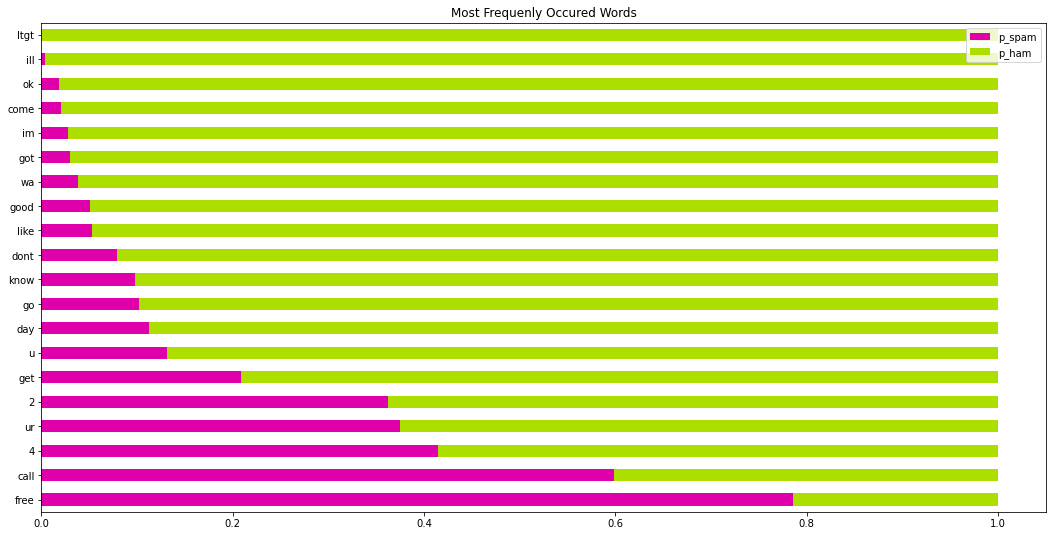

In [19]:
# visualizing word frequency
word_counts.assign(p_spam=word_counts.spam / word_counts['all'],p_ham=word_counts.ham / word_counts['all'])\
    .sort_values(by='all')\
    .tail(20)\
    [['p_spam', 'p_ham']]\
    .sort_values(by='p_ham')\
    .plot.barh(stacked=True, figsize = (18,9), title = 'Most Frequenly Occured Words', color = ['#DF00AC', '#ACDF00'])

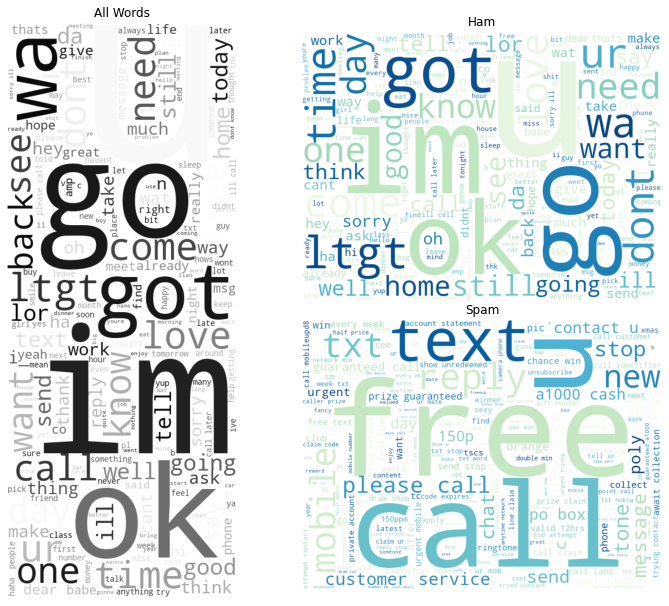

In [38]:
# generate wordcloud for 3 categories
all_cloud = WordCloud(background_color='white', height=1000, width=400, colormap = 'binary').generate(all_text)
ham_cloud = WordCloud(background_color='white', height=600, width=800, colormap = 'GnBu').generate(ham_text)
spam_cloud = WordCloud(background_color='white', height=600, width=800, colormap = 'GnBu').generate(spam_text)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

### c. Is there any overlap in the bigrams for the spam data and the ham data?


Yes, 'free', 'call', 'ur', etc. are frequently occuring words for both spam and ham data.

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [28]:
# trigram analysis
pd.Series(nltk.ngrams(all_text.split(), 3)).value_counts().head(20)

(ill, call, later)            42
(sorry, ill, call)            38
(prize, guaranteed, call)     21
(u, wan, 2)                   21
(happy, new, year)            19
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(pls, send, message)          13
(private, 2003, account)      13
(2003, account, statement)    13
(right, pls, send)            12
(phone, right, pls)           12
(pick, phone, right)          12
(cant, pick, phone)           12
(camcorder, reply, call)      12
(guaranteed, a1000, cash)     12
(show, 800, unredeemed)       12
(hi, hi, hi)                  11
(please, call, customer)      11
dtype: int64

<AxesSubplot:title={'center':'Top 20 Most Frequent Tri-grams'}>

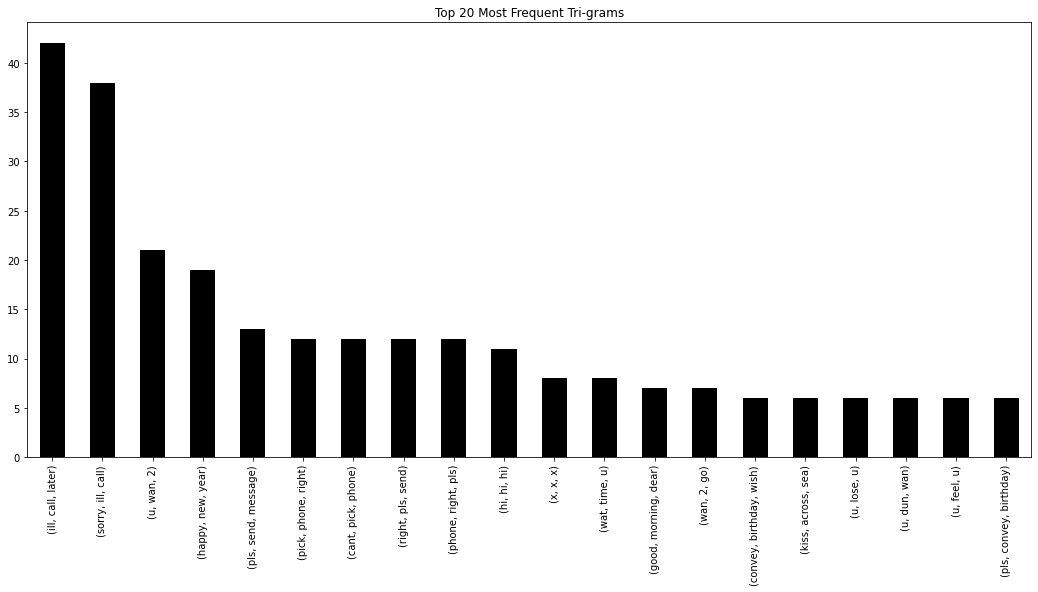

In [32]:
pd.Series(nltk.ngrams(ham_text.split(), 3)).value_counts().head(20).plot.bar(
    figsize=(18,8), color = 'black', title = 'Top 20 Most Frequent Tri-grams')

In [33]:
# store top 20 trigrams into series
top_20_ham_trigrams = pd.Series(
    (
        nltk.ngrams(
            ham_text.split(), 3
        )
    )).value_counts().head(20)

In [34]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_trigrams.to_dict().items()}

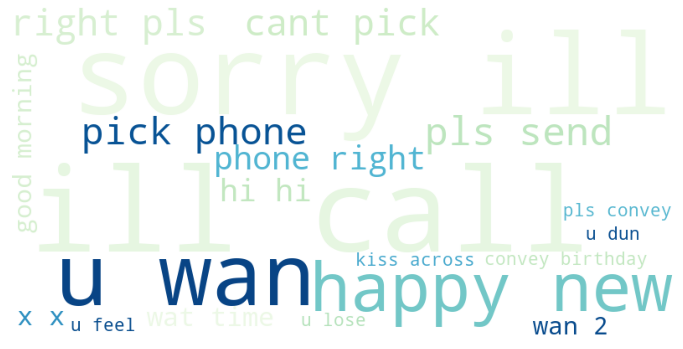

In [39]:
# visualize top trigrams
img = WordCloud(background_color='white', width=800, height=400, colormap = 'GnBu_r').generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


## 2. Explore the blog articles using the techniques discussed in the exploration lesson./

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the `category` variable when exploring.

In [45]:
# read in article
df_news = pd.read_csv('clean_articles.csv')

In [47]:
df_news.head()

,title,content,category,clean,stemmed,lemmatized
0,Don't eff this up: Bezos recalls warning from ...,Ahead of the debut of The Lord of the Rings' p...,business,ahead debut lord rings prequel rings power ama...,ahead debut lord ring prequel ring power amazo...,ahead debut lord ring prequel ring power amazo...
1,US sought records on Binance CEO for crypto mo...,US prosecutors sought communication records in...,business,us prosecutors sought communication records in...,us prosecutor sought commun record involv bina...,u prosecutor sought communication record invol...
2,Price of commercial LPG cylinders cut by up to...,State-owned fuel retailers on Thursday announc...,business,stateowned fuel retailers thursday announced r...,stateown fuel retail thursday announc reduct p...,stateowned fuel retailer thursday announced re...
3,Chairman of Russia's 2nd largest oil firm dies...,The chairman of Russia's second-largest oil pr...,business,chairman russias secondlargest oil producer lu...,chairman russia secondlargest oil produc lukoi...,chairman russia secondlargest oil producer luk...
4,SpiceJet shares fall nearly 15% after CFO resi...,SpiceJet shares declined nearly 15% during Thu...,business,spicejet shares declined nearly 15 thursdays i...,spicejet share declin nearli 15 thursday intra...,spicejet share declined nearly 15 thursday int...


In [48]:
# aggregate on category and store the frequency in a dataframe
labels = pd.concat([df_news.category.value_counts(),
                    df_news.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
business,25,0.252525
sports,25,0.252525
entertainment,25,0.252525
technology,24,0.242424


In [49]:
# store each category into variables
all_news = ' '.join(df_news.content)
tech_news = ' '.join(df_news[df_news.category == 'technology'].content)
bus_news = ' '.join(df_news[df_news.category == 'business'].content)
sports_news = ' '.join(df_news[df_news.category == 'sports'].content)
ent_news = ' '.join(df_news[df_news.category == 'entertainment'].content)

In [51]:
# store each category word counts into variables and check all text word count
all_freq = pd.Series(all_news.split()).value_counts()
tech_freq = pd.Series(tech_news.split()).value_counts()
bus_freq = pd.Series(bus_news.split()).value_counts()
sports_freq = pd.Series(sports_news.split()).value_counts()
ent_freq = pd.Series(ent_news.split()).value_counts()

all_freq

the          225
to           135
in           127
of           123
and          117
            ... 
off...to       1
[took]         1
fact           1
jokingly.      1
is."           1
Length: 2469, dtype: int64

In [52]:
news_word_counts = (pd.concat([all_freq, tech_freq, bus_freq, sports_freq, ent_freq], axis=1, sort=True))\
    .set_axis(['all', 'technology', 'business', 'sports', 'entertainment'], axis=1, inplace=False)

<AxesSubplot:title={'center':'Top Words Sort by Business'}>

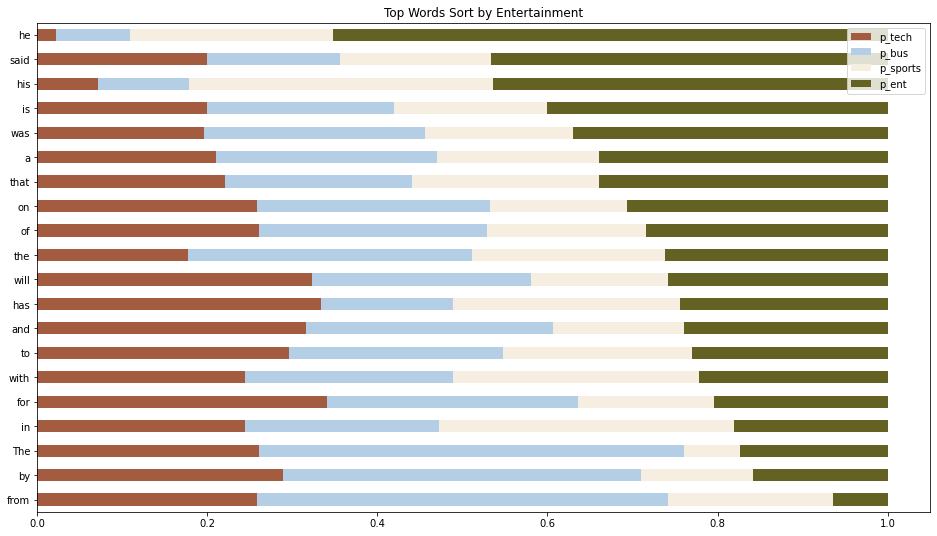

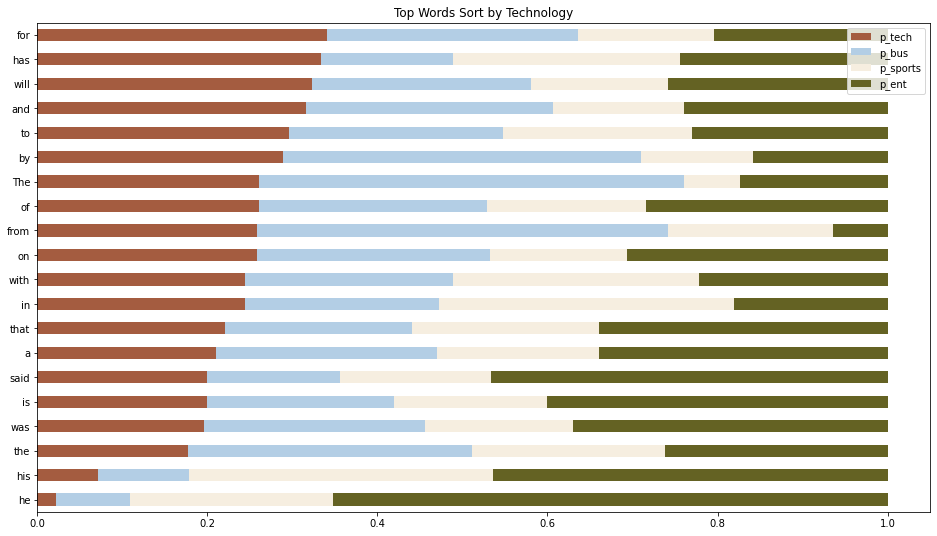

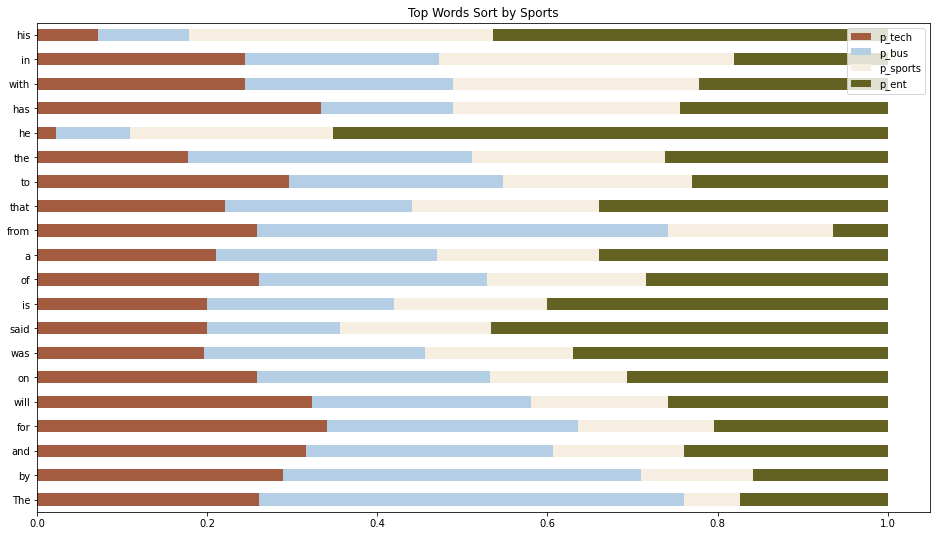

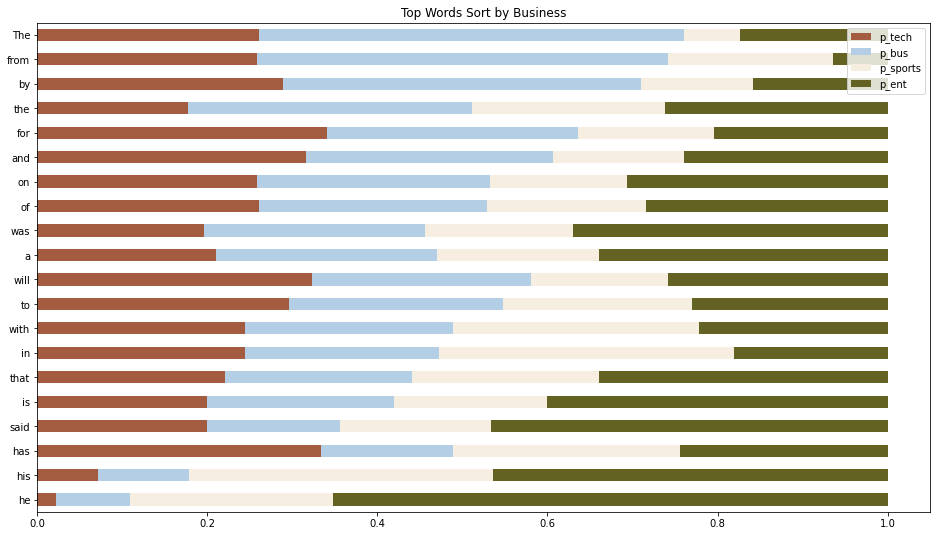

In [57]:
# visualizing most frequent words sort by each category
news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_ent')\
                        .plot.barh(stacked=True, figsize = (16,9), title = 'Top Words Sort by Entertainment', color = ['#a45c40', '#b3cee5', '#f6eee0', '#646223'])
                        

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_tech')\
                        .plot.barh(stacked=True, figsize = (16,9), title = 'Top Words Sort by Technology', color = ['#a45c40', '#b3cee5', '#f6eee0', '#646223'])

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_sports')\
                        .plot.barh(stacked=True, figsize = (16,9), title = 'Top Words Sort by Sports', color = ['#a45c40', '#b3cee5', '#f6eee0', '#646223'])

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_bus')\
                        .plot.barh(stacked=True, figsize = (16,9), title = 'Top Words Sort by Business', color = ['#a45c40', '#b3cee5', '#f6eee0', '#646223'])